In [1]:
import h5py
import numpy as np
import pandas as pd
import os
from scipy.spatial import KDTree
from scipy.interpolate import griddata
pd.set_option('display.max.rows',5000)
from datetime import datetime,timedelta
from tqdm import tqdm
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import xarray
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from global_land_mask import globe
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [2]:

s3a_folder = r'F:\esa\s3a_excel'
all_s3a_data = [] 

for csv_file in os.listdir(s3a_folder):
    file_path = os.path.join(s3a_folder, csv_file)
    if file_path.lower().endswith('.csv'):
        try:
            s3a_df = pd.read_csv(file_path)
            s3a_df['Date'] = pd.to_datetime(s3a_df['Date'])
            all_s3a_data.append(s3a_df)  
        except Exception as e:
            print(f"Error processing file {csv_file}: {e}")


combined_s3a_df = pd.concat(all_s3a_data).sort_values('Date')
combined_s3a_df.dropna(subset=['SSHA_DTU21'], inplace=True)

In [3]:

s3b_folder = r'F:\esa\s3b_excel'
all_s3b_data = [] 

for csv_file in os.listdir(s3b_folder):
    file_path = os.path.join(s3b_folder, csv_file)
    if file_path.lower().endswith('.csv'):
        try:
            s3b_df = pd.read_csv(file_path)
            s3b_df['Date'] = pd.to_datetime(s3b_df['Date'])
            all_s3b_data.append(s3b_df)  
        except Exception as e:
            print(f"Error processing file {csv_file}: {e}")


combined_s3b_df = pd.concat(all_s3b_data).sort_values('Date')
combined_s3b_df.dropna(subset=['SSHA_DTU21'], inplace=True)

In [4]:
df_gt2r = pd.read_csv(r"F:\nasa\is2\atl12\beams\gt2r_ssha.csv")
df_gt2r['Date'] = pd.to_datetime(df_gt2r['Date'])
df_gt2r

,Unnamed: 0,Longitude,Latitude,SSH,Date,MSS,SSHA
0,0,138.502422,0.007555,71.387596,2018-10-14,72.136479,-0.748883
1,1,138.500893,0.022813,71.504170,2018-10-14,72.185855,-0.681682
2,2,138.499719,0.034543,71.526750,2018-10-14,72.224116,-0.697367
3,3,138.498193,0.049790,71.548170,2018-10-14,72.274422,-0.726250
4,4,138.497017,0.061525,71.602670,2018-10-14,72.312755,-0.710086
...,...,...,...,...,...,...,...
1138394,1138394,103.563480,6.604381,-4.628600,2023-06-21,-3.836282,-0.792318
1138395,1138395,103.557578,6.545553,-4.471357,2023-06-21,-3.682668,-0.788688
1138396,1138396,103.551575,6.485769,-4.301078,2023-06-21,-3.512742,-0.788336
1138397,1138397,103.545491,6.425159,-4.150082,2023-06-21,-3.335271,-0.814811


In [5]:
import pandas as pd
combined_s3a_df.rename(columns = {'SSHA_DTU21':'SSHA'},inplace= True)
combined_s3b_df.rename(columns = {'SSHA_DTU21':'SSHA'},inplace= True)
def remove_outliers(df, column_name):
    """ 移除基于三倍标准差的异常值 """
    mean_value = df[column_name].mean()
    std_value = df[column_name].std()
    lower_bound = mean_value - 3 * std_value
    upper_bound = mean_value + 3 * std_value
    return df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]



df_gt2r_clean = remove_outliers(df_gt2r, 'SSHA')
combined_s3a_df_clean = remove_outliers(combined_s3a_df, 'SSHA')
combined_s3b_df_clean = remove_outliers(combined_s3b_df, 'SSHA')



In [ ]:
monthly_avgssha_combined_gt2r = df_gt2r_clean.resample('M', on='Date').mean()['SSHA']
monthly_avgssha_combined_gt2r.index = monthly_avgssha_combined_gt2r.index.to_period('M').to_timestamp('M') + pd.offsets.MonthBegin(n=0)
monthly_avgssha_combined_gt2r 

In [ ]:
monthly_avgssha_combined_b = combined_s3b_df_clean.resample('M', on='Date').mean()['SSHA']
monthly_avgssha_combined_b.index = monthly_avgssha_combined_b.index.to_period('M').to_timestamp('M') + pd.offsets.MonthBegin(n=0)
monthly_avgssha_combined_b 

In [7]:
grid_res = 0.5
lon_min, lon_max, lat_min, lat_max = 100, 140, 0, 50

# 创建经纬度的边界坐标
lon_edges = np.linspace(lon_min, lon_max, int((lon_max - lon_min) / grid_res) + 1)
lat_edges = np.linspace(lat_min, lat_max, int((lat_max - lat_min) / grid_res) + 1)

# 生成经纬度的中心点坐标
lon_centers = (lon_edges[:-1] + lon_edges[1:]) / 2
lat_centers = (lat_edges[:-1] + lat_edges[1:]) / 2

# 创建经纬度的网格中心点
grid_lon, grid_lat = np.meshgrid(lon_centers, lat_centers)

# 使用 global_land_mask 确定哪些格网点是陆地
is_land = globe.is_land(grid_lat, grid_lon)

In [8]:
df_gt2r_clean.loc[:, 'grid_lon_idx'] = np.floor((df_gt2r_clean['Longitude'] - lon_min) / grid_res)
df_gt2r_clean.loc[:, 'grid_lat_idx'] = np.floor((df_gt2r_clean['Latitude'] - lat_min) / grid_res)


# 按格网单元索引分组，并计算平均SSHA_DTU21
grouped = df_gt2r_clean.groupby(['grid_lon_idx', 'grid_lat_idx'])
grid_averages = grouped['SSHA'].mean().reset_index()

# 初始化全格网数组为NaN
full_grid = np.full((int((lat_max - lat_min) / grid_res), int((lon_max - lon_min) / grid_res)), np.nan)


for index, row in grid_averages.iterrows():
    lon_idx = int(row['grid_lon_idx'])
    lat_idx = int(row['grid_lat_idx'])
    
    # 防止索引越界
    if lon_idx < full_grid.shape[1] and lat_idx < full_grid.shape[0]:
        full_grid[lat_idx, lon_idx] = row['SSHA']

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11436\2292779319.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gt2r_clean.loc[:, 'grid_lon_idx'] = np.floor((df_gt2r_clean['Longitude'] - lon_min) / grid_res)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11436\2292779319.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gt2r_clean.loc[:, 'grid_lat_idx'] = np.floor((df_gt2r_clean['Latitude'] - lat_min) / grid_res)


In [9]:
combined_s3a_df_clean.loc[:, 'grid_lon_idx'] = np.floor((combined_s3a_df_clean['Longitude'] - lon_min) / grid_res)
combined_s3a_df_clean.loc[:, 'grid_lat_idx'] = np.floor((combined_s3a_df_clean['Latitude'] - lat_min) / grid_res)


# 按格网单元索引分组，并计算平均SSHA_DTU21
grouped = combined_s3a_df_clean.groupby(['grid_lon_idx', 'grid_lat_idx'])
grid_averages = grouped['SSHA'].mean().reset_index()

# 初始化全格网数组为NaN
full_grid = np.full((int((lat_max - lat_min) / grid_res), int((lon_max - lon_min) / grid_res)), np.nan)


for index, row in grid_averages.iterrows():
    lon_idx = int(row['grid_lon_idx'])
    lat_idx = int(row['grid_lat_idx'])
    
    # 防止索引越界
    if lon_idx < full_grid.shape[1] and lat_idx < full_grid.shape[0]:
        full_grid[lat_idx, lon_idx] = row['SSHA']

In [10]:
combined_s3b_df_clean.loc[:, 'grid_lon_idx'] = np.floor((combined_s3b_df_clean['Longitude'] - lon_min) / grid_res)
combined_s3b_df_clean.loc[:, 'grid_lat_idx'] = np.floor((combined_s3b_df_clean['Latitude'] - lat_min) / grid_res)

# 按格网单元索引分组，并计算平均SSHA_DTU21
grouped = combined_s3b_df_clean.groupby(['grid_lon_idx', 'grid_lat_idx'])
grid_averages = grouped['SSHA'].mean().reset_index()

# 初始化全格网数组为NaN
full_grid = np.full((int((lat_max - lat_min) / grid_res), int((lon_max - lon_min) / grid_res)), np.nan)


for index, row in grid_averages.iterrows():
    lon_idx = int(row['grid_lon_idx'])
    lat_idx = int(row['grid_lat_idx'])
    
    # 防止索引越界
    if lon_idx < full_grid.shape[1] and lat_idx < full_grid.shape[0]:
        full_grid[lat_idx, lon_idx] = row['SSHA']

In [11]:
def count_data_points(df, grid_lon, grid_lat, grid_res):
    # 创建一个空的numpy数组来存储数据点的数量
    count_grid = np.zeros(grid_lon.shape, dtype=int)

    # 对于每个格网点
    for i in range(grid_lon.shape[0]):
        for j in range(grid_lon.shape[1]):
            # 确定周围0.25°范围内的点
            lon_min, lon_max = grid_lon[i, j] - grid_res / 2, grid_lon[i, j] + grid_res / 2
            lat_min, lat_max = grid_lat[i, j] - grid_res / 2, grid_lat[i, j] + grid_res / 2

            # 从DataFrame中选取在当前范围内的点
            subset = df[(df['Longitude'] >= lon_min) & (df['Longitude'] <= lon_max) &
                        (df['Latitude'] >= lat_min) & (df['Latitude'] <= lat_max)]

            # 计算这些点的数量并赋值给对应的格网点
            count_grid[i, j] = len(subset)

    return count_grid

In [12]:
def calculate_ssha_std(df, grid_lon, grid_lat, grid_res):
    # 创建一个空的numpy数组来存储标准差
    std_grid = np.empty(grid_lon.shape)
    std_grid.fill(np.nan)  # 用nan初始化

    # 对于每个格网点
    for i in range(grid_lon.shape[0]):
        for j in range(grid_lon.shape[1]):
            # 确定周围0.25°范围内的点
            lon_min, lon_max = grid_lon[i, j] - grid_res / 2, grid_lon[i, j] + grid_res / 2
            lat_min, lat_max = grid_lat[i, j] - grid_res / 2, grid_lat[i, j] + grid_res / 2

            # 从DataFrame中选取在当前范围内的点
            subset = df[(df['Longitude'] >= lon_min) & (df['Longitude'] <= lon_max) &
                        (df['Latitude'] >= lat_min) & (df['Latitude'] <= lat_max)]

            # 如果格网点周围有数据点，计算这些点的SSHA值的标准差
            if not subset.empty:
                std_grid[i, j] = subset['SSHA'].std()

    return std_grid

In [13]:
def calculate_seasonal_ssha(season_df):
    season_df['grid_lon_idx'] = np.floor((season_df['Longitude'] - lon_min) / grid_res)
    season_df['grid_lat_idx'] = np.floor((season_df['Latitude'] - lat_min) / grid_res)
    
    # 按格网单元索引分组，并计算平均SSHA_DTU21
    grouped = season_df.groupby(['grid_lon_idx', 'grid_lat_idx'])
    grid_averages = grouped['SSHA'].mean().reset_index()
    
    # 创建临时的全格网数组
    temp_grid = np.full(full_grid.shape, np.nan)
    for index, row in grid_averages.iterrows():
        lon_idx = int(row['grid_lon_idx'])
        lat_idx = int(row['grid_lat_idx'])
        
        if lon_idx < temp_grid.shape[1] and lat_idx < temp_grid.shape[0]:
            temp_grid[lat_idx, lon_idx] = row['SSHA']
    
    return temp_grid

In [ ]:
#ssha直方图
output_folder = r'F:\s3asshahi'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

for year in range(2019, 2023):
    for season in ['JFM', 'AMJ', 'JAS', 'OND']:
        # 筛选特定季节的数据
        mask = (combined_s3a_df_clean['Date'].dt.year == year) & (combined_s3a_df_clean['Date'].dt.month.isin(season_months[season]))
        season_df = combined_s3a_df_clean.loc[mask].copy()

        # 计算SSHA值
        ssha_grid = calculate_seasonal_ssha(season_df)

        # 处理NaN和无限值
        ssha_grid_flat = ssha_grid.flatten()
        ssha_grid_flat = ssha_grid_flat[~np.isnan(ssha_grid_flat) & ~np.isinf(ssha_grid_flat)]

        # 绘制直方图
        plt.figure(figsize=(8, 6))
        plt.hist(ssha_grid_flat, bins=30, color='blue', alpha=0.7)
        plt.title(f'SSHA Histogram for {season} {year}')
        plt.xlabel('SSHA (m)')
        plt.ylabel('Frequency')

        # 计算20分位数和80分位数并显示
        percentile_20 = np.percentile(ssha_grid_flat, 20)
        percentile_80 = np.percentile(ssha_grid_flat, 80)

        plt.axvline(percentile_20, color='green', linestyle='dashed', linewidth=1)
        plt.text(percentile_20, plt.ylim()[1]*0.9, f'20th Percentile: {percentile_20:.2f}', color='green')

        plt.axvline(percentile_80, color='red', linestyle='dashed', linewidth=1)
        plt.text(percentile_80, plt.ylim()[1]*0.8, f'80th Percentile: {percentile_80:.2f}', color='red')

        # 构造文件名并保存图像
        filename = os.path.join(output_folder, f'SSHA_Histogram_{year}_{season}.png')
        plt.savefig(filename, dpi=400)
        plt.close() 

In [15]:
season_months = {
    'JFM': [1, 2, 3],
    'AMJ': [4, 5, 6],
    'JAS': [7, 8, 9],
    'OND': [10, 11, 12]
}
# vmin, vmax = np.nanpercentile(combined_s3a_df['SSHA_DTU21'], [15, 85])


In [ ]:
# 绘图设置
n_rows, n_cols = 4, 4 
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 20), subplot_kw={'projection': ccrs.Mercator()}, constrained_layout=True)
axs = axs.ravel()
plot_count = 0  
for year in range(2019, 2023):
    for i, season in enumerate(['JFM', 'AMJ', 'JAS', 'OND']):
        ax = axs[plot_count]  # 使用 plot_count 作为一维索引
        plot_count += 1

        # 筛选特定季节的数据
        mask = (df_gt2r['Date'].dt.year == year) & (df_gt2r['Date'].dt.month.isin(season_months[season]))
        season_df = df_gt2r[mask].copy() 

        # 计算 SSHA 值的平均值
        ssha_grid = calculate_seasonal_ssha(season_df)  
        masked_data = np.ma.masked_where(is_land, ssha_grid)

        # 绘制数据
        img = ax.pcolormesh(grid_lon, grid_lat, masked_data, transform=ccrs.PlateCarree(),
                            cmap='coolwarm', vmin=vmin, vmax=vmax)

        # 添加地图特征和标题
        ax.coastlines()
        ax.add_feature(cfeature.LAND)
        ax.add_feature(cfeature.OCEAN)
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.set_title(f'{season} {year}')

# 添加共用的颜色条
cbar = fig.colorbar(img, ax=axs, orientation='horizontal', fraction=0.05, pad=0.01, ticks=[vmin, -0.7, -0.6, vmax])
cbar.set_label('SSHA (m)', size=12)
plt.savefig(r'D:\BF\Desktop\gt2r_season_sshagrid.png',dpi = 400)
plt.show()

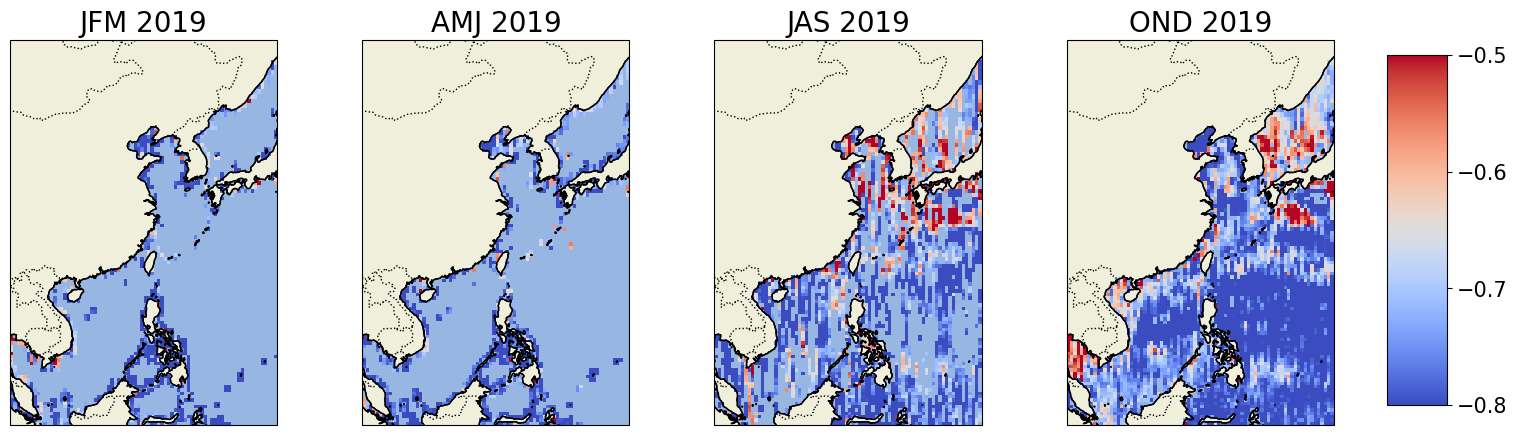

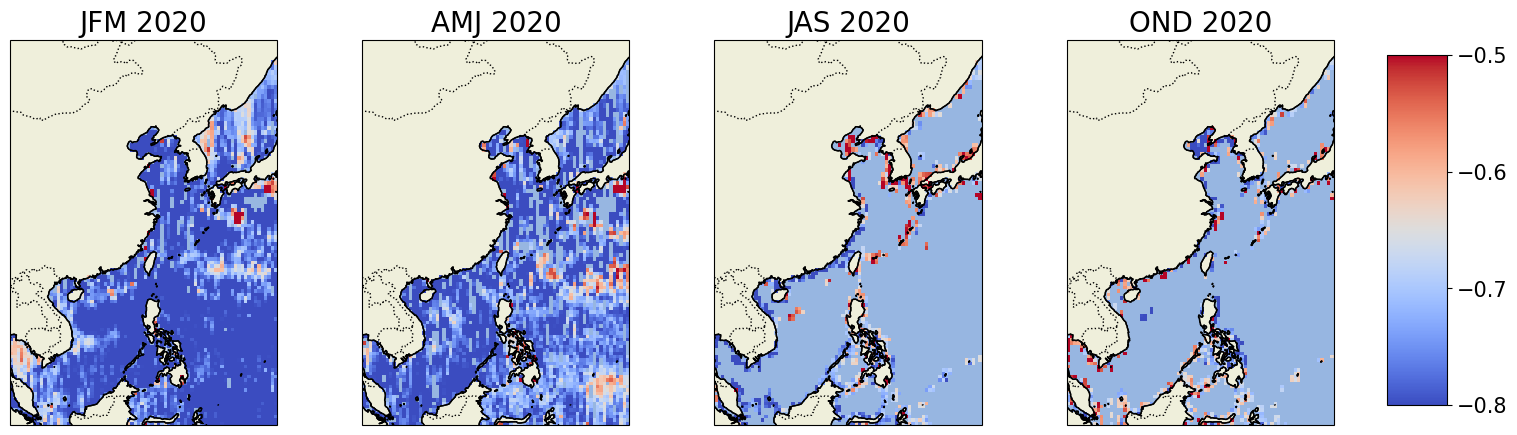

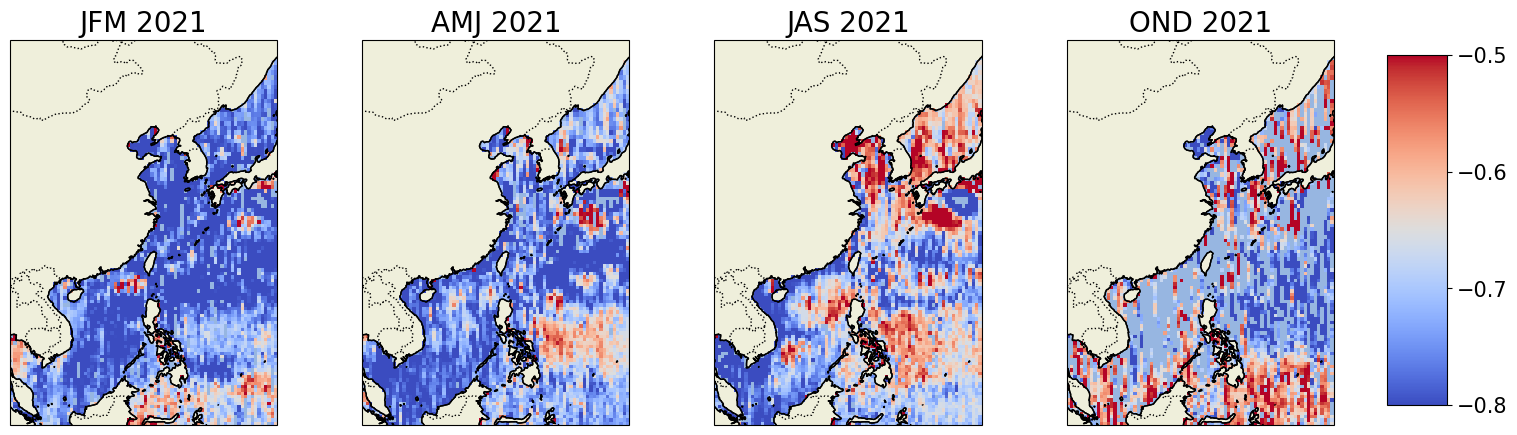

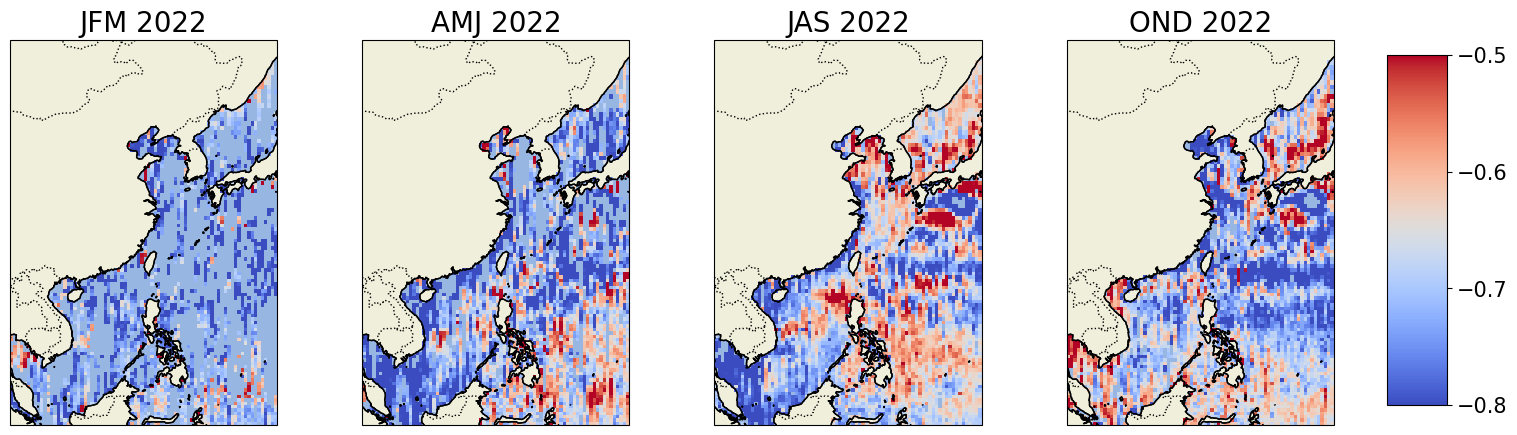

In [21]:
#绘制四张1x4的ssha图

vmin, vmax = -0.8, -0.5

# 遍历每一年，创建一张图表
for year_idx, year in enumerate(range(2019, 2023)):
    # 创建每年的子图
    fig, axs = plt.subplots(1, 4, figsize=(20, 5), subplot_kw={'projection': ccrs.Mercator()})  # 1行4列
    for season_idx, season in enumerate(['JFM', 'AMJ', 'JAS', 'OND']):
        ax = axs[season_idx]  # 直接使用season_idx索引
        # 筛选对应年份和季节的数据
        mask = (combined_s3b_df_clean['Date'].dt.year == year) & (combined_s3b_df_clean['Date'].dt.month.isin(season_months[season]))
        season_df = combined_s3b_df_clean[mask].copy()

        # 计算SSHA值的平均值
        ssha_grid = calculate_seasonal_ssha(season_df)
        masked_data = np.ma.masked_where(is_land, ssha_grid)

        # 绘制数据
        img = ax.pcolormesh(grid_lon, grid_lat, masked_data, transform=ccrs.PlateCarree(), cmap='coolwarm', vmin=vmin, vmax=vmax)

        # 添加地图特征和标题
        ax.coastlines()
        ax.add_feature(cfeature.LAND)
        ax.add_feature(cfeature.OCEAN)
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.set_title(f'{season} {year}',fontsize = 20)

    # 调整子图布局并添加颜色条
    fig.subplots_adjust(right=0.8, hspace=0.05)
    cbar_ax = fig.add_axes([0.82, 0.15, 0.03, 0.7])  # 调整颜色条位置
    cbar = fig.colorbar(img, cax=cbar_ax, ticks=[vmin, -0.7, -0.6, vmax])
    cbar.ax.tick_params(labelsize=15)
#     cbar.set_label('SSHA (m)', size=20)

    # 保存每年的图像
    plt.savefig(f'D:\\BF\\Desktop\\s3b_season_sshagrid_{year}.png', dpi=400,bbox_inches = 'tight')
    plt.show()


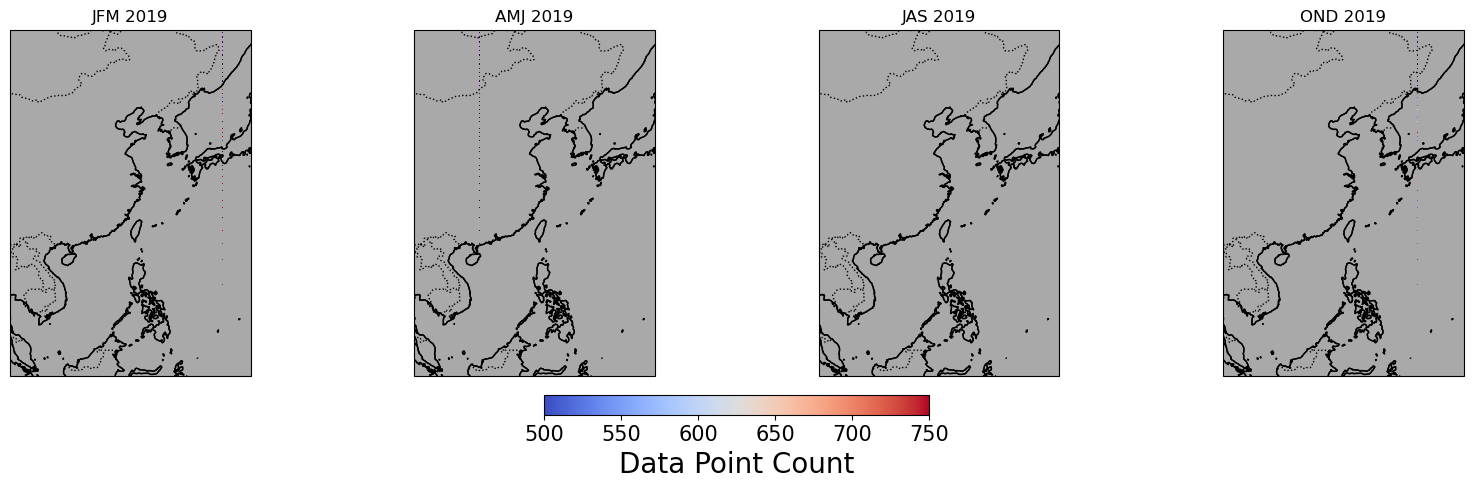

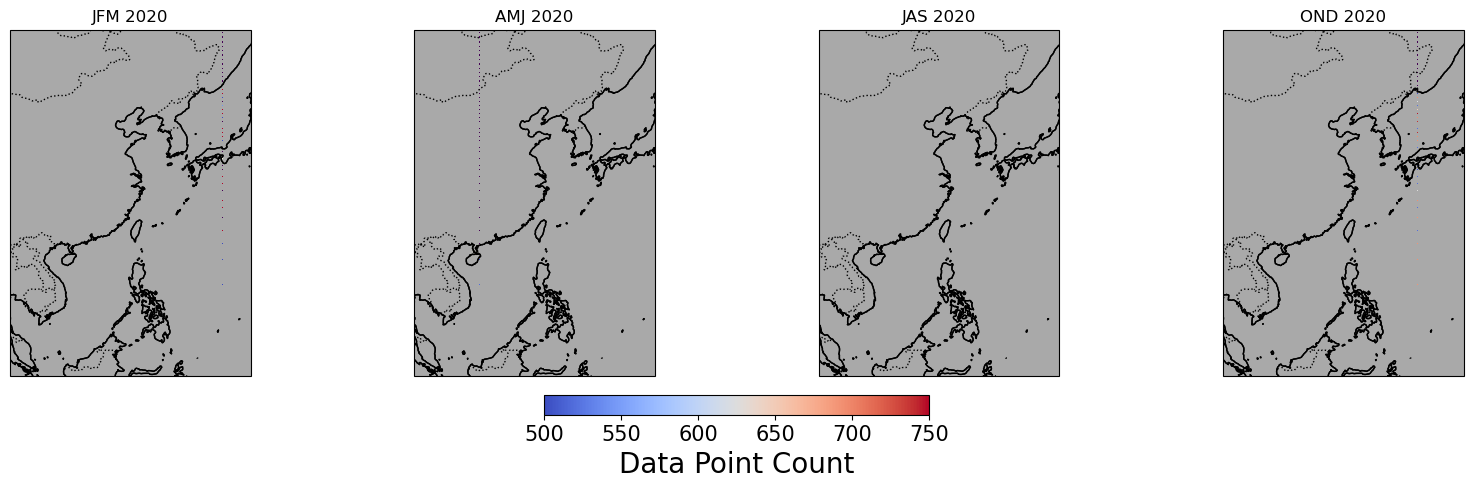

KeyboardInterrupt: 

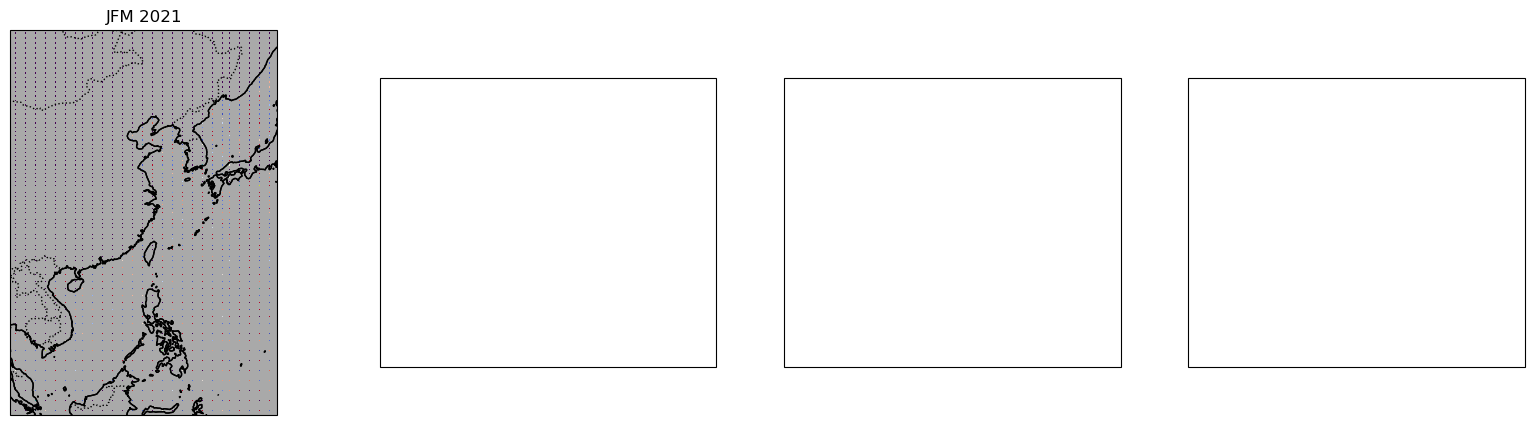

In [23]:

low_threshold, high_threshold = 30, 120
# 遍历每一年，创建一张图表
for year in range(2019, 2023):
    # 创建每年的子图
    fig, axs = plt.subplots(1, 4, figsize=(20, 5), subplot_kw={'projection': ccrs.Mercator()})
    for season_idx, season in enumerate(['JFM', 'AMJ', 'JAS', 'OND']):
        ax = axs[season_idx]  # 直接使用season_idx索引
        # 筛选对应年份和季节的数据
        mask = (combined_s3a_df_clean['Date'].dt.year == year) & (combined_s3a_df_clean['Date'].dt.month.isin(season_months[season]))
        season_df = combined_s3a_df_clean[mask].copy()
        
        # 计算数据点的数量
        count_grid = count_data_points(season_df, grid_lon, grid_lat, 0.5)  # 确保传入正确的grid_res
        # 应用颜色阈值
        masked_count_low = np.ma.masked_where((count_grid >= low_threshold) | is_land, count_grid)
        masked_count_high = np.ma.masked_where((count_grid <= high_threshold) | is_land, count_grid)

        # 绘制数据
        ax.pcolormesh(grid_lon, grid_lat, masked_count_high, transform=ccrs.PlateCarree(), cmap='Greens', vmin=30, vmax=120)
        ax.pcolormesh(grid_lon, grid_lat, masked_count_low, transform=ccrs.PlateCarree(), color='yellow')

        # 添加地图特征和标题
        ax.coastlines()
        ax.add_feature(cfeature.LAND)
        ax.add_feature(cfeature.OCEAN)
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.set_title(f'{season} {year}', fontsize=20)

    # 调整子图布局并添加颜色条
    fig.subplots_adjust(right=0.85, hspace=0.05)
    cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])  # 调整颜色条位置
    # 创建一个伪造的Image对象，因为colorbar需要基于实际的图像来显示
    cbar = fig.colorbar(sm, cax=cbar_ax,ticks=[low_threshold, 60, 90, high_threshold])
    cbar.ax.tick_params(labelsize=15)
    cbar.set_label('Data Point Count', size=20)

    
#     plt.savefig(f'D:\\BF\\Desktop\\s3a_season_count_{year}.png', dpi=400, bbox_inches='tight')
    plt.show()

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import os

output_folder = r'D:\BF\Desktop\s3acounthi'
for year in range(2019, 2023):
    for season in ['JFM', 'AMJ', 'JAS', 'OND']:
        # 筛选特定季节的数据
        mask = (combined_s3a_df_clean['Date'].dt.year == year) & (
            combined_s3a_df_clean['Date'].dt.month.isin(season_months[season]))
        season_df = combined_s3a_df_clean[mask]

        # 计算数据点数量
        count_grid = count_data_points(season_df, grid_lon, grid_lat, grid_res)

        # 绘制直方图
        plt.figure(figsize=(7, 7))
        n, bins, patches = plt.hist(count_grid.flatten(), bins=30, edgecolor='black', color='#87CEFA', alpha=0.7)
        plt.title(f'Data Point Count Histogram for {season} {year}')
        plt.xlabel('Data Point Count')
        plt.ylabel('Frequency')
        plt.grid(axis='y', alpha=0.75)  # 添加网格线仅在y轴方向

        # 计算80分位数并显示
        percentile_80 = np.percentile(count_grid, 80)
        plt.axvline(percentile_80, color='black', linestyle='dashed', linewidth=2)
        plt.text(percentile_80, plt.ylim()[1] * 0.9, f'80th Percentile: {percentile_80:.2f}', color='black')

        # 移除上边界和右边界
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)

        # 构造文件名并保存图像
        filename = os.path.join(output_folder, f'count_{year}_{season}.png')
        plt.savefig(filename, dpi=400, bbox_inches='tight')
        plt.close()


KeyboardInterrupt: 

In [19]:
#只输出2019年amj的
import matplotlib.pyplot as plt
import numpy as np
import os

output_folder = r'D:\BF\Desktop\s3acounthi'
# 设置特定的年份和季节
year = 2019
season = 'AMJ'

# 筛选特定季节的数据
mask = (combined_s3a_df_clean['Date'].dt.year == year) & (
    combined_s3a_df_clean['Date'].dt.month.isin(season_months[season]))
season_df = combined_s3a_df_clean[mask]

# 计算数据点数量
count_grid = count_data_points(season_df, grid_lon, grid_lat, grid_res)

# 绘制直方图
plt.figure(figsize=(7, 7))
n, bins, patches = plt.hist(count_grid.flatten(), bins=30, edgecolor='black', color='#87CEFA', alpha=0.7)
# plt.title(f'Data Point Count Histogram for {season} {year}') 这里记得改成 不要年份 以示总体情况
# plt.xlabel('Data Point Count')
# plt.ylabel('Frequency')
# plt.grid(axis='y', alpha=0.75)  # 添加网格线仅在y轴方向

# 计算80分位数并显示
percentile_80 = np.percentile(count_grid, 80)
plt.axvline(percentile_80, color='black', linestyle='dashed', linewidth=2)
# plt.text(percentile_80, plt.ylim()[1] * 0.9, f'80th Percentile: {percentile_80:.2f}', color='black')

# 移除上边界和右边界
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# 构造文件名并保存图像
filename = os.path.join(output_folder, f'count_{year}_{season}.png')
plt.savefig(filename, dpi=400, bbox_inches='tight')
plt.close()


In [ ]:
# 数据点SSHA标准差
fig2, axs2 = plt.subplots(n_rows,
                          n_cols,
                          figsize=(20, 20),
                          subplot_kw={'projection': ccrs.Mercator()},
                          constrained_layout=True)
axs2 = axs2.ravel()
plot_count2 = 0
vmin, vmax = 0, 1
for year in range(2019, 2023):
    for i, season in enumerate(['JFM', 'AMJ', 'JAS', 'OND']):
        ax = axs2[plot_count2]  # 使用 plot_count 作为一维索引
        plot_count2 += 1

        # 筛选特定季节的数据
        mask = (combined_s3a_df_clean['Date'].dt.year == year) & (
            combined_s3a_df_clean['Date'].dt.month.isin(season_months[season]))
        season_df = combined_s3a_df_clean[mask].copy()

        # 计算SSHA标准差
        std_grid = calculate_ssha_std(season_df, grid_lon, grid_lat, grid_res)
        masked_std = np.ma.masked_where(is_land, std_grid)

        # 绘制SSHA标准差图
        img2 = ax.pcolormesh(grid_lon,
                             grid_lat,
                             masked_std,
                             transform=ccrs.PlateCarree(),
                             cmap='coolwarm',
                             vmin=vmin,
                             vmax=vmax)

        # 添加地图特征和标题
        ax.coastlines()
        ax.add_feature(cfeature.LAND)
        ax.add_feature(cfeature.OCEAN)
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.set_title(f'{season} {year}')

# 添加共用的颜色条 - SSHA标准差
cbar2 = fig2.colorbar(img2,
                      ax=axs2,
                      orientation='horizontal',
                      fraction=0.05,
                      pad=0.01,
                      ticks=[0, 0.2, 0.4, 0.8, 1])
cbar2.set_label('SSHA Standard Deviation (m)', size=12)

plt.savefig(r'D:\BF\Desktop\s3a_season_sshastd.png', dpi=400)
plt.show()

In [22]:
import os
#sd直方图
output_folder = r"C:\Users\pc\Desktop\s3asdhi"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

for year in range(2019, 2023):
    for season in ['JFM', 'AMJ', 'JAS', 'OND']:
        # 筛选特定季节的数据
        mask = (combined_s3a_df_clean['Date'].dt.year == year) & (
            combined_s3a_df_clean['Date'].dt.month.isin(season_months[season]))
        season_df = combined_s3a_df_clean[mask]

        # 计算SSHA标准差
        std_grid = calculate_ssha_std(season_df, grid_lon, grid_lat, grid_res)
        std_grid = std_grid[np.isfinite(std_grid)]
        if std_grid.size > 0:
            plt.figure(figsize=(8, 6))
            plt.hist(std_grid.flatten(), bins=30, color='green', alpha=0.7)
            plt.title(f'SSHA Standard Deviation Histogram for {season} {year}')
            plt.xlabel('SSHA Standard Deviation (m)')
            plt.ylabel('Frequency')

            percentile_80 = np.percentile(std_grid, 80)
            plt.axvline(percentile_80,
                        color='red',
                        linestyle='dashed',
                        linewidth=1)
            plt.text(percentile_80,
                     plt.ylim()[1] * 0.9,
                     f'80th Percentile: {percentile_80:.2f}',
                     color='red')

            filename = os.path.join(output_folder,
                                    f'SSHA_Std_{year}_{season}.png')
            plt.savefig(filename, dpi=400)
            plt.close()

In [23]:
#只输出2019amj的
import matplotlib.pyplot as plt
import numpy as np
import os

output_folder = r'D:\BF\Desktop\s3asdhi'
# 设置特定的年份和季节
year = 2019
season = 'AMJ'

# 筛选特定季节的数据
mask = (combined_s3a_df_clean['Date'].dt.year == year) & (
    combined_s3a_df_clean['Date'].dt.month.isin(season_months[season]))
season_df = combined_s3a_df_clean[mask]

# 计算数据点数量
std_grid = calculate_ssha_std(season_df, grid_lon, grid_lat, grid_res)
std_grid = std_grid[np.isfinite(std_grid)]
if std_grid.size > 0:
            plt.figure(figsize=(8, 6))
            plt.hist(std_grid.flatten(), bins=30, color='#87CEFA', alpha=0.7)
#             plt.title(f'SSHA Standard Deviation Histogram for {season} {year}')
#             plt.xlabel('SSHA Standard Deviation (m)')
#             plt.ylabel('Frequency')

            percentile_80 = np.percentile(std_grid, 80)
            plt.axvline(percentile_80,
                        color='black',
                        linestyle='dashed',
                        linewidth=2)
            plt.gca().spines['top'].set_visible(False)
            plt.gca().spines['right'].set_visible(False)
#             plt.text(percentile_80,
#             plt.ylim()[1] * 0.9,
#                f'80th Percentile: {percentile_80:.2f}',
#                       color='red')

            filename = os.path.join(output_folder,
                                    f'SSHA_Std_{year}_{season}.png')
            plt.savefig(filename, dpi=400,bbox_inches = 'tight')
            plt.close()


In [25]:
#只输出2019amj的
import matplotlib.pyplot as plt
import numpy as np
import os

output_folder = r'D:\BF\Desktop\s3bsdhi'
# 设置特定的年份和季节
year = 2019
season = 'AMJ'

# 筛选特定季节的数据
mask = (combined_s3b_df_clean['Date'].dt.year == year) & (
    combined_s3b_df_clean['Date'].dt.month.isin(season_months[season]))
season_df = combined_s3b_df_clean[mask]

# 计算数据点数量
std_grid = calculate_ssha_std(season_df, grid_lon, grid_lat, grid_res)
std_grid = std_grid[np.isfinite(std_grid)]
if std_grid.size > 0:
            plt.figure(figsize=(8, 6))
            plt.hist(std_grid.flatten(), bins=30, color='#87CEFA', alpha=0.7)
#             plt.title(f'SSHA Standard Deviation Histogram for {season} {year}')
#             plt.xlabel('SSHA Standard Deviation (m)')
#             plt.ylabel('Frequency')

            percentile_80 = np.percentile(std_grid, 80)
            plt.axvline(percentile_80,
                        color='black',
                        linestyle='dashed',
                        linewidth=2)
            plt.gca().spines['top'].set_visible(False)
            plt.gca().spines['right'].set_visible(False)
#             plt.text(percentile_80,
#             plt.ylim()[1] * 0.9,
#                f'80th Percentile: {percentile_80:.2f}',
#                       color='red')

            filename = os.path.join(output_folder,
                                    f'SSHA无标识_Std_{year}_{season}.png')
            plt.savefig(filename, dpi=400,bbox_inches = 'tight')
            plt.close()


In [19]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
vmin,vmax = 0,0.15

for year in range(2019, 2023):  # 遍历每年
    # 每年创建一个新的图形
    fig, axs = plt.subplots(1, 4, figsize=(20, 5), subplot_kw={'projection': ccrs.Mercator()})  # 一行四列，代表四个季节
    
    for season_idx, season in enumerate(['JFM', 'AMJ', 'JAS', 'OND']):  # 遍历四个季节
        ax = axs[season_idx]  # 选择对应的子图
        mask = (combined_s3a_df_clean['Date'].dt.year == year) & (combined_s3a_df_clean['Date'].dt.month.isin(season_months[season]))
        season_df = combined_s3a_df_clean[mask].copy()

        std_grid = calculate_ssha_std(season_df, grid_lon, grid_lat, grid_res)
        masked_std = np.ma.masked_where(is_land, std_grid)

        # 绘制每个季节的数据
        img = ax.pcolormesh(grid_lon, grid_lat, masked_std, transform=ccrs.PlateCarree(), cmap='coolwarm', vmin=vmin, vmax=vmax)

        ax.coastlines()
        ax.add_feature(cfeature.LAND)
        ax.add_feature(cfeature.OCEAN)
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.set_title(f'{season} {year}')

    # 调整子图位置
    fig.subplots_adjust(right=0.8, hspace=0.05, wspace=0.05)
    cbar_ax = fig.add_axes([0.82, 0.15, 0.03, 0.7])  # 调整颜色条位置
    cbar = fig.colorbar(img, cax=cbar_ax, fraction=0.05, pad=0.01, ticks=[vmin, 0.05, 0.10, vmax])
    cbar.ax.tick_params(labelsize=15)
#     cbar.set_label('SD(m)', size=20)

    # 保存每年的图像
    plt.savefig(f'D:\BF\Desktop\s3asdseason\s3a_season_sd_{year}.png', dpi=400, bbox_inches='tight')
    plt.close()


In [20]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
vmin,vmax = 0,0.15

for year in range(2019, 2023):  # 遍历每年
    # 每年创建一个新的图形
    fig, axs = plt.subplots(1, 4, figsize=(20, 5), subplot_kw={'projection': ccrs.Mercator()})  # 一行四列，代表四个季节
    
    for season_idx, season in enumerate(['JFM', 'AMJ', 'JAS', 'OND']):  # 遍历四个季节
        ax = axs[season_idx]  # 选择对应的子图
        mask = (combined_s3b_df_clean['Date'].dt.year == year) & (combined_s3b_df_clean['Date'].dt.month.isin(season_months[season]))
        season_df = combined_s3b_df_clean[mask].copy()

        std_grid = calculate_ssha_std(season_df, grid_lon, grid_lat, grid_res)
        masked_std = np.ma.masked_where(is_land, std_grid)

        # 绘制每个季节的数据
        img = ax.pcolormesh(grid_lon, grid_lat, masked_std, transform=ccrs.PlateCarree(), cmap='coolwarm', vmin=vmin, vmax=vmax)

        ax.coastlines()
        ax.add_feature(cfeature.LAND)
        ax.add_feature(cfeature.OCEAN)
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.set_title(f'{season} {year}')

    # 调整子图位置
    fig.subplots_adjust(right=0.8, hspace=0.05, wspace=0.05)
    cbar_ax = fig.add_axes([0.82, 0.15, 0.03, 0.7])  # 调整颜色条位置
    cbar = fig.colorbar(img, cax=cbar_ax, fraction=0.05, pad=0.01, ticks=[vmin, 0.05, 0.10, vmax])
    cbar.ax.tick_params(labelsize=15)
#     cbar.set_label('SD(m)', size=20)

    # 保存每年的图像
    plt.savefig(f'D:\BF\Desktop\s3bsdseason\s3b_season_sd_{year}.png', dpi=400, bbox_inches='tight')
    plt.close()


In [10]:
ssha_std_3a = combined_s3a_df_clean['SSHA'].std()
ssha_std_3b = combined_s3b_df_clean['SSHA'].std()
ssha_std_gt2r = df_gt2r_clean['SSHA'].std()
print('s3a的SSHA标准差是:', ssha_std_3a, '\n',
      's3b的SSHA标准差是:', ssha_std_3b, '\n',
      'gt2r的SSHA标准差是:', ssha_std_gt2r)
ssha_std_3a = combined_s3a_df_clean

s3a的SSHA标准差是: 0.1925136309636017 
 s3b的SSHA标准差是: 0.1904145112562916 
 gt2r的SSHA标准差是: 0.1423792882049804


In [6]:
del combined_s3b_df
del combined_s3a_df
del df_gt2r

In [9]:
ssha_std_3a = combined_s3a_df['SSHA_DTU21'].std()
ssha_std_3b = combined_s3b_df['SSHA_DTU21'].std()
ssha_std_gt2r = df_gt2r['SSHA'].std()
print('s3a的SSHA标准差是:', ssha_std_3a, '\n',
      's3b的SSHA标准差是:', ssha_std_3b, '\n',
      'gt2r的SSHA标准差是:', ssha_std_gt2r)

NameError: name 'combined_s3a_df' is not defined